In [1]:
%config Completer.use_jedi = False # To make auto-complete faster

#Reloads imported files automatically
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../utils/')

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:87% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os

from shapely.geometry import MultiPoint, Point, Polygon

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.path as mpltPath

from matplotlib_param_funcs import set_matplotlib_params,reset_rcParams
set_matplotlib_params()

In [3]:
import compute_variables as CV
import miscellaneous_functions as MF
import mixed_plots as MP
import plotting_helpers as PH
import ellipse_functions as EF
import load_data
import map_functions as mapf

import dynamical_binning as dyn

In [6]:
coolwarm = mplcmaps["coolwarm"]

In [7]:
full_map_string_list,divergent_map_list = mapf.get_map_string_lists()

# Load

In [9]:
general_path = "/Users/Luismi/Desktop/MRes_UCLan/"

In [229]:
# obs_errors = True
obs_errors = False

GSR=True
# GSR=False

zabs = True
# zabs = False

R0 = 8.1

In [230]:
dummy_df = pd.DataFrame([[1,2,3],[2,3,1],[6,3,4]], columns=['a','b','c'])

data = load_data.load_and_process_data(error_bool=obs_errors, zabs=zabs, R0=R0, GSR=GSR)

Working with zabs == True; GSR == True.
Found 13031 total stars.
Removed 2545 bad indices, leaving 10486 stars.


# Spatial cuts

In [18]:
# extra_variable = "d"
extra_variable = "R"

In [19]:
# original limits
original_lmin,original_lmax = data["l"].min(),data["l"].max()
original_bmin,original_bmax = data["b"].min(),data["b"].max()
original_extramin,original_extramax = data[extra_variable].min(),data[extra_variable].max()

print("Original limits:")
print("l",(original_lmin,original_lmax)); print("b",(original_bmin,original_bmax)); print(extra_variable,(original_extramin,original_extramax))

Original limits:
l (-10.866571323000016, 10.8611888062)
b (0.00189518279518, 12.9924198102)
R (0.00306188035932205, 3.5994273617403696)


In [359]:
lmin = -11
lmax = 11

bmin = 0 if zabs else -13
bmax = 13

extra_min = 0
extra_max = 3.5
# extra_max = original_extramax

print("l",(lmin,lmax)); print("b",(bmin,bmax)); print(extra_variable,(extra_min,extra_max))

extra_var_string = ""
if extra_min != original_extramin or extra_max != original_extramax:
    extra_var_string = f"_{extra_min if extra_min != original_extramin else ''}{extra_variable}{extra_max if extra_max != original_extramax else ''}"

l (-11, 11)
b (0, 13)
R (0, 3.5)


visualise_cuts_dmax11.6_lmax11_bmax13_R08.1_R_gc3.5_Rshift0.1


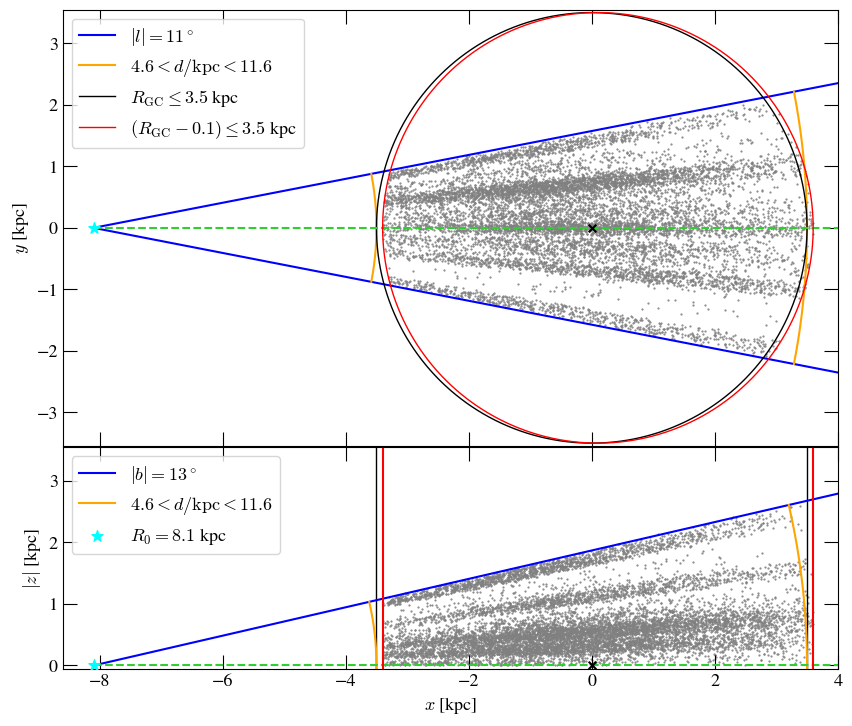

In [1211]:
R_shift = 0.1
# R_shift = None

# save_bool = True
save_bool = False

if True:
    fig,axs=plt.subplots(figsize=(10,10),nrows=2,sharex=True,gridspec_kw={"hspace":-0.25,"height_ratios":[1,0.5]})

    dmax = extra_max if extra_variable=="d" else R0+3.5
    R_max = extra_max if extra_variable=="R" else 3.5
    plot_cuts = {"dmax":dmax,"lmax":lmax,"bmax":bmax,"R0":R0,"R_gc":R_max}
    MP.visualise_bulge_selection(cuts=plot_cuts,given_axs=axs)
    
    axs[0].scatter(data["x"],data["y"],s=0.3,color="grey")
    axs[1].scatter(data["x"],data["z"],s=0.3,color="grey")
    
    if R_shift is not None:
        MP.plot_circle(axs[0],radius=3.5,centre=[R_shift,0],color="r",label=r"$(R_\mathrm{GC}-%s)\leq %s$ kpc"%(R_shift,3.5),lw=1)
        axs[1].axvline(x=-3.5+R_shift,color="red")
        axs[1].axvline(x=3.5+R_shift,color="red")
        
    axs[0].legend()
    axs[1].legend()
    
    if True: # filename and saving
        filename = f"visualise_cuts"
        for cut in plot_cuts:
            filename += f"_{cut}{plot_cuts[cut]}"

        if R_shift is not None:
            filename += f"_Rshift{R_shift}"

        if save_bool:
            if os.path.isdir("graphs/other_plots/visualise_bulge_cuts/"):
                save_path = "graphs/other_plots/visualise_bulge_cuts/"
            else:
                raise ValueError("Save path not specified")

            for fileformat in [".png"]:
                plt.savefig(save_path+filename+fileformat, dpi=200,bbox_inches="tight")
                print("Saved",save_path+filename+fileformat)
        else:
            print(filename)
    
    plt.show()

In [364]:
data_spatial = data[(data["l"]>=lmin)&(data["l"]<=lmax)&(data["b"]>=bmin)&(data["b"]<=bmax)&(data[extra_variable]>=extra_min)&(data[extra_variable]<extra_max)]

if len(data_spatial) != len(data):
    print("Removed",len(data)-len(data_spatial),"stars")
    print(len(data_spatial),"stars left out of the initial",len(data))

Removed 58 stars
10428 stars left out of the initial 10486


# Metallicity cuts

In [365]:
# metal_trim = float("-inf")
metal_trim = -1

data_trim = data_spatial[data_spatial['FeH']>=metal_trim]

print(f"Chose minimum metallicity of {metal_trim}" if metal_trim != float("-inf") else "No minimum metallicity")
print(len(data_trim),"stars left")

Chose minimum metallicity of -1
9884 stars left


In [366]:
metallicity_median = MF.return_int_or_dec(np.median(data_trim["FeH"]),2)
print("Median:",metallicity_median)
print("Stars above:",np.sum(data_trim['FeH']>=metallicity_median))
print("Stars below:",np.sum(data_trim['FeH']<metallicity_median))

Median: -0.21
Stars above: 4971
Stars below: 4913


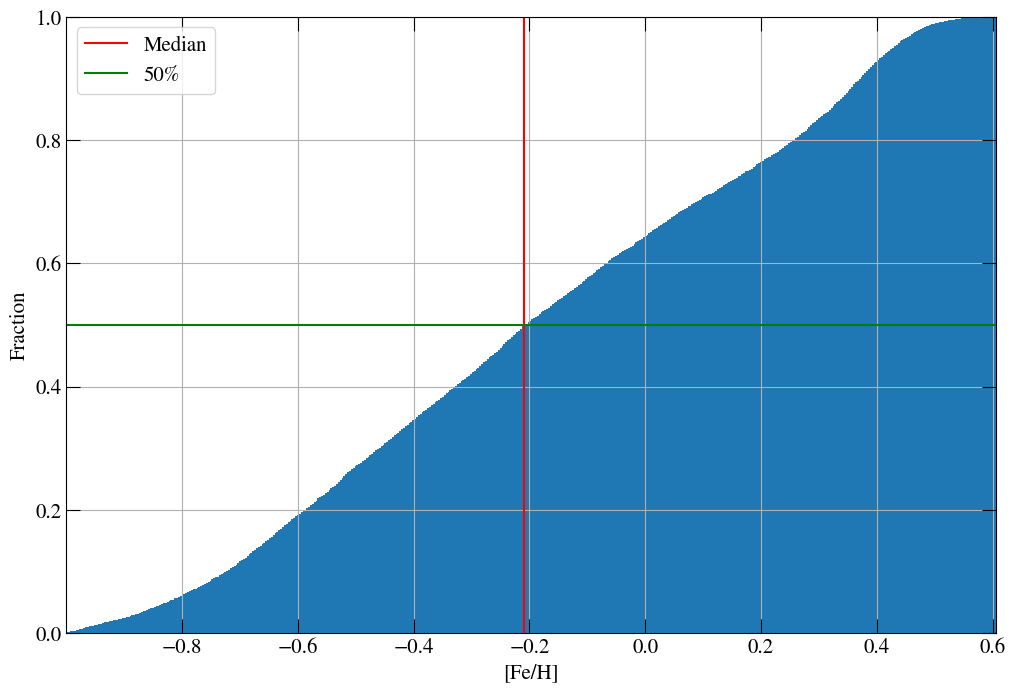

In [343]:
# metal cumulative
fig,ax=plt.subplots()
ax.hist(data_trim['FeH'],cumulative=True,density=True,bins=500)
ax.grid(which='both')
ax.axvline(x=metallicity_median,color="red",label="Median")
ax.axhline(y=0.5,color="green",label="50%")
ax.set_xlabel("[Fe/H]");ax.set_ylabel("Fraction")
ax.set_xlim([data_trim["FeH"].min(),data_trim["FeH"].max()])
ax.set_ylim([0,1])
plt.legend()
plt.show()

In [367]:
metal_poor_lowlim = None
metal_poor_highlim = metallicity_median

metal_rich_lowlim = metallicity_median
metal_rich_highlim = None

In [368]:
# populations and labels

if metal_rich_highlim is None:
    rich_condition = data_trim["FeH"] >= metal_rich_lowlim
    label_rich = fr'[Fe/H]$~>{str(metal_rich_lowlim)}$'
else:
    rich_condition = (data_trim["FeH"] <= metal_rich_highlim)&(data_trim["FeH"] >= metal_rich_lowlim)
    label_rich = fr'${str(metal_rich_lowlim)}<~$[Fe/H]/dex$~<{str(metal_rich_highlim)}$'
    
if metal_poor_lowlim is None:
    poor_condition = data_trim["FeH"] < metal_poor_highlim
    label_poor = fr'[Fe/H]$~<{str(metal_poor_highlim)}$'
else:
    poor_condition = (data_trim["FeH"] < metal_poor_highlim)&(data_trim["FeH"] > metal_poor_lowlim)
    label_poor = fr'${str(metal_poor_lowlim)}<~$[Fe/H]/dex$~<{str(metal_poor_highlim)}$'

df_metals = [data_trim[rich_condition], data_trim[poor_condition]]
# label_rich += f" ({len(df_metals[0])})"
# label_poor += f" ({len(df_metals[1])})"

print("Rich",label_rich, len(df_metals[0]))
print("Poor",label_poor, len(df_metals[1]))

Rich [Fe/H]$~>-0.21$ 4971
Poor [Fe/H]$~<-0.21$ 4913


# Functions

In [1282]:
def compute_mean(df, **kws):
    return np.mean(df[kws["vel"]].values)

def compute_std(df, **kws):
    return np.std(df[kws["vel"]].values)

def compute_correlation(df, **kws):
    return CV.calculate_correlation(df[kws["vx"]].values,df[kws["vy"]].values)

def compute_anisotropy(df, **kws):
    return CV.calculate_anisotropy(df[kws["vx"]].values,df[kws["vy"]].values)

def compute_tilt_abs(df, **kws):
    return CV.calculate_tilt(df[kws["vx"]].values,df[kws["vy"]].values,absolute=True)

def compute_error(df, **kws):
    return CV.get_std_bootstrap(df[kws["vx"]].values,df[kws["vy"]].values, function=kws["function"], tilt=kws["tilt"], absolute=kws["absolute"], repeat=kws["repeat"])

def compute_fractional_error(df, **kws):
    function = kws["function"]
    
    error = CV.get_std_bootstrap(df[kws["vx"]].values,df[kws["vy"]].values, function=function, tilt=kws["tilt"], absolute=kws["absolute"], repeat=kws["repeat"])
    value = function(df[kws["vx"]].values,df[kws["vy"]].values)
    
    return error/abs(value)

In [1265]:
def get_compute_variable_error_function(map_variable):
    if map_variable == "correlation":
        return CV.calculate_correlation
    elif map_variable == "anisotropy":
        return CV.calculate_anisotropy
    elif map_variable == "tilt_abs":
        return CV.calculate_tilt
    else:
        raise ValueError(f"map variable `{map_variable}` not recognised")

def get_compute_variable_function(map_variable):
    if map_variable in ["mean_vx","mean_vy"]:
        return compute_mean
    elif map_variable in ["std_vx","std_vy"]:
        return compute_std
    elif map_variable == "correlation":
        return compute_correlation
    elif map_variable == "anisotropy":
        return compute_anisotropy
    elif map_variable == "tilt_abs":
        return compute_tilt_abs
    elif "fractionalerror" in map_variable:
        return compute_fractional_error
    elif "error" in map_variable:
        return compute_error
    else:
        raise ValueError(f"map variable `{map_variable}` not recognised")

def is_tilt(map_variable):
    return "tilt" in map_variable or "vertex" in map_variable # this considers X_abs too
        
def get_kws_for_error(map_variable, bootstrap_repeat=500):
    if "error" not in map_variable:
        raise ValueError(f"Expected the variable to be a variable error, but found `{map_variable}`.")
    
    error_string = "_fractionalerror" if "_fractionalerror" in map_variable else "_error"
    kinematic_variable = map_variable.replace(error_string,"")
    
    error_kws = {
        "function": get_compute_variable_error_function(kinematic_variable),
         "tilt": is_tilt(kinematic_variable),
         "absolute": is_tilt(kinematic_variable) and "_abs" in kinematic_variable,
         "repeat": bootstrap_repeat
    }
    return error_kws
        
def get_kws_and_compute_variable_function(map_variable, bootstrap_repeat=500):

    if map_variable in ["mean_vx","std_vx"]:
        kws={"vel":f"v{vel_x_variable}"}
    elif map_variable in ["mean_vy","std_vy"]:
        kws={"vel":f"v{vel_y_variable}" if vel_y_variable !="\phi" else "vphi"}
    else:
        kws={"vx":f"v{vel_x_variable}","vy":f"v{vel_y_variable}" if vel_y_variable !="\phi" else "vphi"}

    compute_variable = get_compute_variable_function(map_variable)
    
    if "error" in map_variable:
        error_kws = get_kws_for_error(map_variable, bootstrap_repeat)
        kws = {**kws, **error_kws} # combine dictionaries
        
    return kws, compute_variable

In [1345]:
def get_vminvmax_extend_lists_for_lb_blobhull_maps(df_all, df_hull, map_variable_list, min_star_number_dyn, bootstrap_repeat=500,
                                           x_variable="l", y_variable="b", below_min_number_blobs=False, hardcode=True):
    
    vmin_list,vmax_list,extend_list = np.full(len(map_variable_list),None), np.full(len(map_variable_list),None), np.full(len(map_variable_list),None)

    for row,variable in enumerate(map_variable_list):
        
        if variable != "number":
            kws, compute_variable = get_kws_and_compute_variable_function(variable,bootstrap_repeat=bootstrap_repeat)

        vmin,vmax = float("inf"),float("-inf")

        for col, (pop,pop_hull) in enumerate(zip(df_all,df_hull)):

            if True: # calculate dynamical hull
                x_values_dyn = pop_hull[x_variable].values
                y_values_dyn = pop_hull[y_variable].values
                input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

                pts = MultiPoint([Point(i) for i in input_points_dyn])
                mask = pts.convex_hull

                vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, min_star_number_dyn)
                point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn)
                
                if variable != "number":
                    hull_values = dyn.compute_values(vor.regions, pop_hull, point_region, compute_variable_function=compute_variable,**kws)
                else:
                    hull_values = dyn.compute_values(vor.regions, pop_hull, point_region, compute_variable_function="counts")

            if True: # blobs
                all_x_values = pop[x_variable].values
                all_y_values = pop[y_variable].values

                circle_radii, circle_centres = get_circle_radii_and_centres(pop_idx=col,below_min_number=below_min_number_blobs)

                circle_values = []

                for radius,centre in zip(circle_radii,circle_centres):
                    points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)
                    
                    if variable != "number":
                        circle_values.append(compute_variable(pop.iloc[points_inside], **kws))
                    else:
                        circle_values.append(sum(points_inside))
                circle_values = np.array(circle_values)

            vmin = min(vmin,np.nanmin(np.concatenate([hull_values,circle_values])))
            vmax = max(vmax,np.nanmax(np.concatenate([hull_values,circle_values])))
            
        set_hardcode = False
        if hardcode:
            if "fractionalerror" in variable:
                hard_vmin,hard_vmax = 0,1.5
                vmin_list[row],vmax_list[row],extend_list[row] = hard_vmin,hard_vmax,PH.get_cbar_extend(hard_vmin,hard_vmax,vmin,vmax)
                set_hardcode = True
            
        if not set_hardcode:
            vmin_list[row],vmax_list[row],extend_list[row] = vmin,vmax,"neither"
    
    return vmin_list,vmax_list,extend_list

# Dynamical + blobs

## Params

In [1253]:
min_star_number_dyn = 50
min_star_number_blobs = 30

bootstrap_repeat = 500

In [1254]:
vel_x_variable = "r"
vel_y_variable = "l"

x_variable = "l"
y_variable = "b"

In [1255]:
degree_symbol = '^\circ'

In [1256]:
kinematic_symbols_dict = mapf.get_kinematic_symbols_dict(x_variable=x_variable,
                                                         y_variable=y_variable,
                                                         vel_x_variable=vel_x_variable,
                                                         vel_y_variable=vel_y_variable)

kinematic_units_dict = mapf.get_kinematic_units_dict(position_variables=x_variable+y_variable,
                                                     vel_x_variable=vel_x_variable,
                                                     vel_y_variable=vel_y_variable,
                                                     degree_symbol=degree_symbol)

In [1257]:
variable_symbol_dict, units_dict = mapf.get_position_symbols_and_units_dict(zabs=zabs, degree_symbol=degree_symbol)

In [1258]:
tick_step = 3

In [1259]:
# map dictionaries

xy_max = 3
z_max = 2
long_max = 15
lat_max = 15

map_min_dict = {
    "l" : -long_max,
    "b" : 0 if zabs else -lat_max,
    "d" : 6,
    "x" : -xy_max,
    "y" : -xy_max,
    "z" : -z_max,
    "R" : 0.1,
    "phi" : -180
}
map_max_dict = {
    "l" : long_max,
    "b" : lat_max,
    "d" : 10,
    "x" : xy_max,
    "y" : xy_max,
    "z" : z_max,
    "R" : 2, #maybe 1.5 judging by the xy map for 9.8-10 stars
    "phi" : 180
}
map_left_dict,map_right_dict = {},{}
for key in list(map_min_dict.keys()):
    map_left_dict[key] = map_max_dict[key] if key == 'l' else map_min_dict[key]
    map_right_dict[key] = map_min_dict[key] if key == 'l' else map_max_dict[key]

map_tick_step = {
    "l" : 3,
    "b" : 3,
    "d" : 1,
    "x" : 1,
    "y" : 1,
    "z" : 1,
    "R" : 0.5,
    "phi" : 90
}
minor_locator_dict = {
    'R': 0.25,
    'phi': 45,
    'l': 1,
    'b': 1,
    'x': 0.5,
    'y': 0.5,
    "z": 0.5,
    'd': 0.5
}
map_hstep_dict = {
    "l" : (map_max_dict['l']-map_min_dict['l'])/15,   #-10 to 10 with 15 bins gives step of 4/3
    "b" : (map_max_dict['b']-map_min_dict['b'])/10,   #0 to 10 with 10 bins gives step of 1
    "x" : 0.25,   #For -2 to 2 gives 16 bins
    "y" : 0.25,   #-2 to 2 with 16 bins gives step 0.25
    "z" : 0.25,
    "R" : (map_max_dict['R']-map_min_dict['R'])/14,
    "phi" : (map_max_dict['phi']-map_min_dict['phi'])/15  #-180 to 180 with 15 bins gives step 24
}
o_map_hstep_dict = {
    "l" : 3,
    "b" : 3,
    "x" : 0.5,
    "y" : 0.5,
    "z" : 0.5,
}
map_vstep_dict = {
    "l" : (map_max_dict['l']-map_min_dict['l'])/15,   #-10 to 10 with 15 bins gives step of 4/3
    "b" : (map_max_dict['b']-map_min_dict['b'])/10,   #0 to 10 with 10 bins gives step of 1
    "x" : 0.25,   #-2 to 2 with 16 bins gives step 0.25
    "y" : 0.25,   #-2 to 2 with 16 bins gives step 0.25
    "z" : 0.25,
    "R" : (map_max_dict['R']-map_min_dict['R'])/14,
    "phi" : (map_max_dict['phi']-map_min_dict['phi'])/15  #-180 to 180 with 15 bins gives step 24
}
o_map_vstep_dict = {
    "l" : 3,
    "b" : 3,
    "x" : 0.5,
    "y" : 0.5,
    "z" : 0.5
}
#Get the same number of "d" intervals as those of "l", so that the map has square pixels.
#The right d_step is given by l_step*Δd/Δl
map_hstep_dict["d"] = map_vstep_dict["l"]*(map_max_dict["d"]-map_min_dict["d"])/(map_max_dict["l"]-map_min_dict["l"])
map_vstep_dict["d"] = map_hstep_dict["d"]
o_map_hstep_dict["d"] = o_map_vstep_dict["l"]*(map_max_dict["d"]-map_min_dict["d"])/(map_max_dict["l"]-map_min_dict["l"])
o_map_vstep_dict["d"] = o_map_hstep_dict["d"]

### Save path

In [1219]:
# save_path

save_path = general_path + "graphs/Observations/Apogee/dynamical_binning/"
MF.create_dir(save_path)

save_path += "blobs/"
MF.create_dir(save_path)

if not GSR:
    save_path += 'LSR/'
    MF.create_dir(save_path)

save_path += f"{lmin}l{lmax}_{bmin}b{bmax}/"
MF.create_dir(save_path)

if extra_min != original_extramin or extra_max != original_extramax:
    save_path += f"{extra_min}{extra_variable}{extra_max}/"
    MF.create_dir(save_path)

if metal_trim is not None:
    save_path += f"{metal_trim}metal/"
    MF.create_dir(save_path)

save_path += f"{str(metal_poor_lowlim)}to{str(metal_poor_highlim)}_{str(metal_rich_lowlim)}to{str(metal_rich_highlim)}/"
MF.create_dir(save_path)

save_path += f"min{min_star_number_blobs}blobs/"
MF.create_dir(save_path)

save_path_blobs = save_path

save_path += f"min{min_star_number_dyn}dyn/"
MF.create_dir(save_path)

print("SAVING IN\n"+save_path)

SAVING IN
/Users/Luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/dynamical_binning/blobs/-11l11_0b13/0R3.5/-1metal/Noneto-0.21_-0.21toNone/min30blobs/min50dyn/


## Choose limits

### Hull

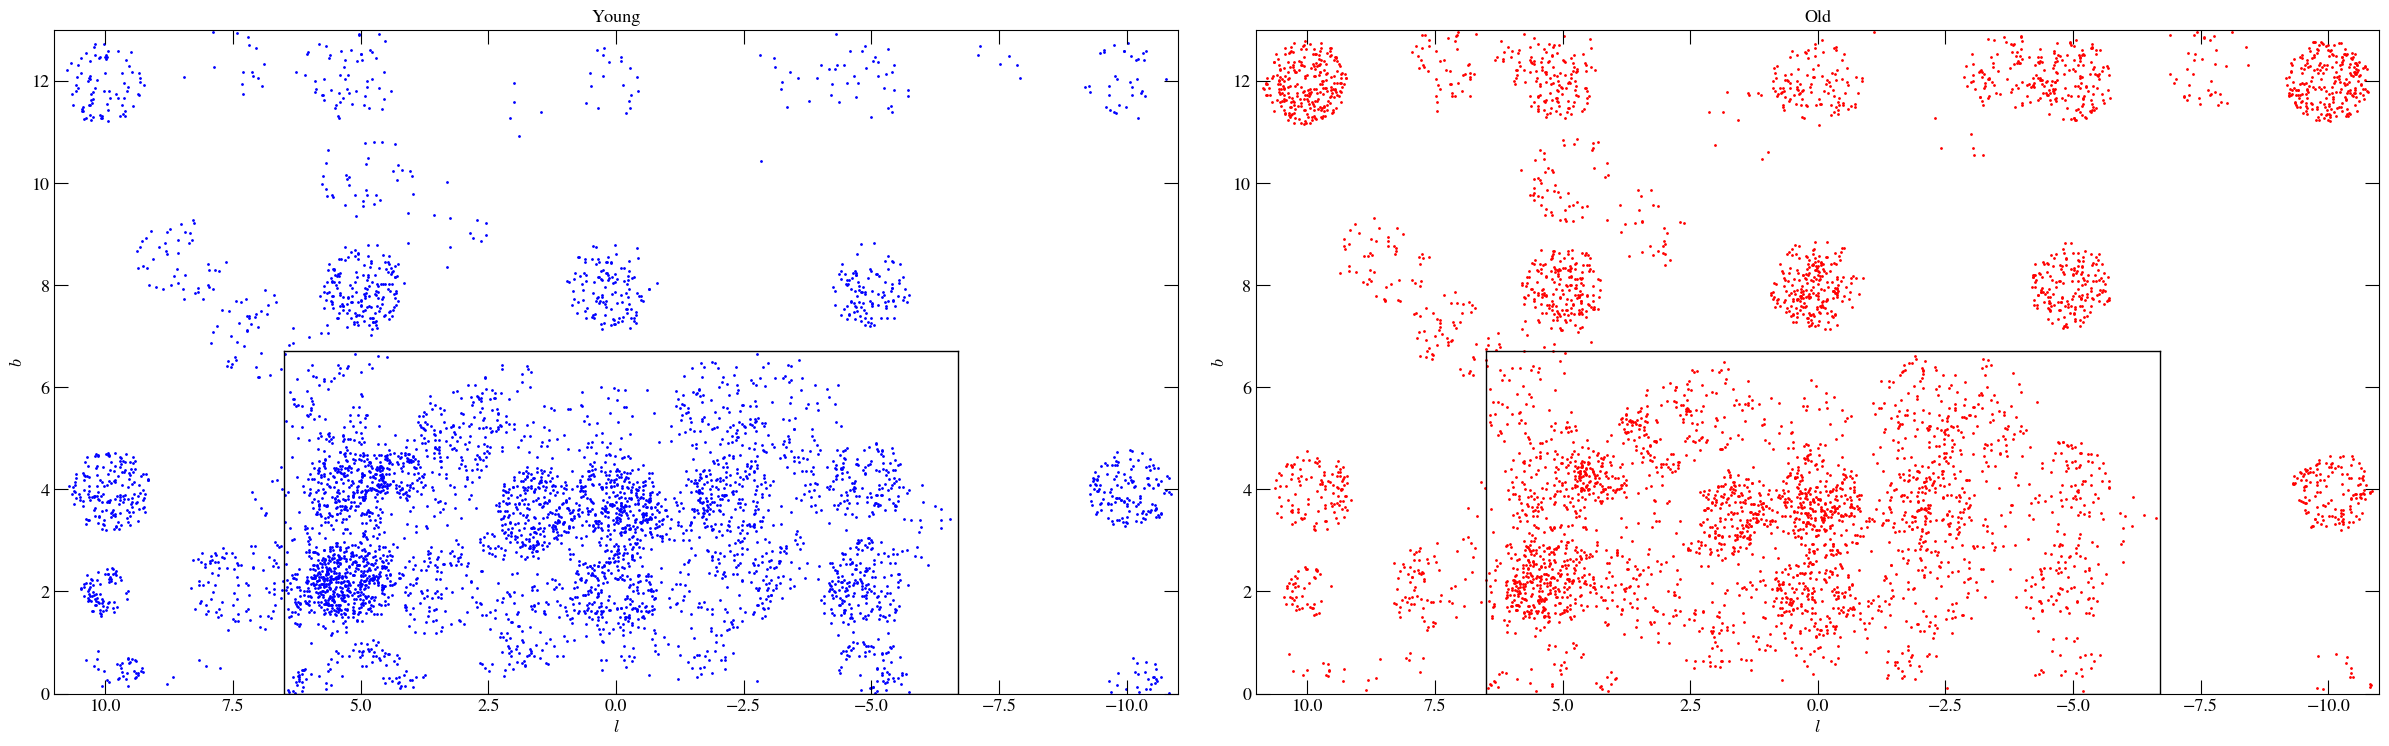

In [1220]:
min_l_dyn = -6.7
max_l_dyn = 6.5
min_b_dyn = 0
max_b_dyn = 6.7

if True: # Scatter only

    fig,axs=plt.subplots(ncols=2,figsize=(30,15),gridspec_kw={"wspace":0.07})
    
    cut_lw = 1
    colors = ["blue","red"]; titles = ["Young","Old"]
    for pop_index,ax in enumerate(axs):
        ax.scatter(df_metals[pop_index][x_variable],df_metals[pop_index][y_variable],s=1,color=colors[pop_index])
        ax.set_aspect("equal"); ax.set_xlim(lmax,lmin);ax.set_ylim(bmin,bmax); ax.set_xlabel(fr"${x_variable}$");ax.set_ylabel(fr"${y_variable}$")
        ax.set_title(titles[pop_index])
        
        ax.plot([min_l_dyn,min_l_dyn],[min_b_dyn,max_b_dyn],color='k',linewidth=cut_lw)
        ax.plot([max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn],color='k',linewidth=cut_lw)
        ax.plot([min_l_dyn,max_l_dyn],[min_b_dyn,min_b_dyn],color='k',linewidth=cut_lw)
        ax.plot([min_l_dyn,max_l_dyn],[max_b_dyn,max_b_dyn],color='k',linewidth=cut_lw)
        
    plt.show()

In [1221]:
dynamical_region_dict = { "min_l": min_l_dyn, "max_l": max_l_dyn, "min_b": min_b_dyn, "max_b": max_b_dyn }

In [1222]:
df_hull = [ 
    df_pop[(df_pop["l"]>min_l_dyn)&(df_pop["l"]<max_l_dyn)&(df_pop["b"]>min_b_dyn)&(df_pop["b"]<max_b_dyn)] 
    for df_pop in df_metals
]

#### Visualise

In [1224]:
dyn_lw = 0.5

scatter_alpha = 1
scatter_size = 0.2
bin_generator_scatter_size = 5
scatter_color = "grey"

# save_bool = True
save_bool = False

plt.rcParams["font.size"] = 15

dyn_counts_min50


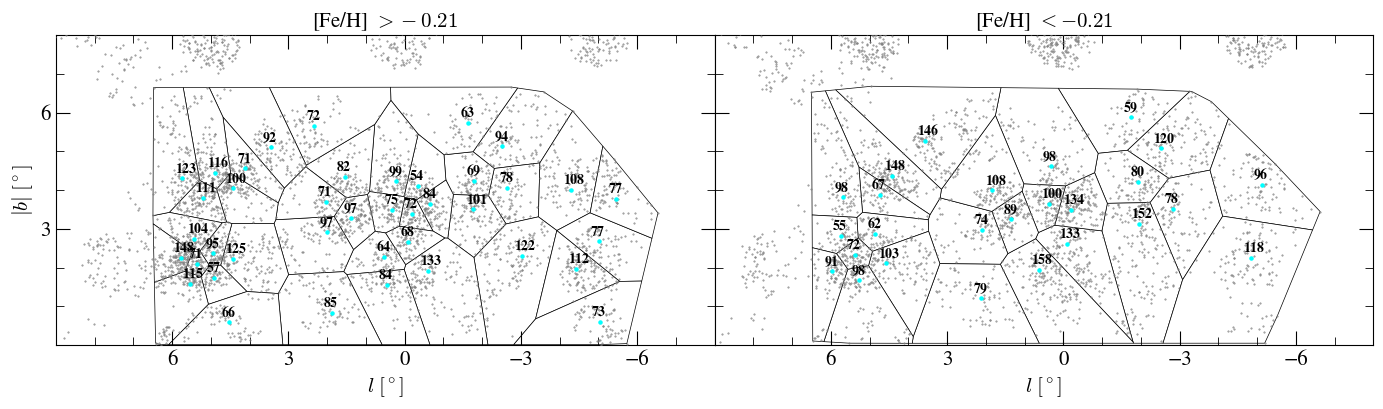

In [1225]:
fig,axs=plt.subplots(figsize=(17,5),ncols=2,gridspec_kw={"wspace":0})

for col in range(len(df_metals)):

    ax = axs[col]

    ax.set_title([label_rich,label_poor][col])

    if True: # dynamical hull
        x_values_dyn = df_hull[col][x_variable].values
        y_values_dyn = df_hull[col][y_variable].values
        input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

        pts = MultiPoint([Point(i) for i in input_points_dyn])
        mask = pts.convex_hull

        vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, min_star_number_dyn)
        point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn)
        computed_values = dyn.compute_values(vor.regions, df_hull[col], point_region, compute_variable_function="counts")

        for i, cell_vertices in enumerate(vor.regions):
            polygon = vor.vertices[cell_vertices]

            shape = list(polygon.shape)
            shape[0] += 1
            p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

            ax.fill(*p.exterior.coords.xy, lw=dyn_lw, edgecolor="k", facecolor="white")#cmap(norm(computed_values[i])))
            
            ax.text(points[:,0][i]+0.2,points[:,1][i]+0.15,color="k",s=int(computed_values[i]),size=10, weight="bold",zorder=20)

    ax.scatter(df_metals[col][x_variable],df_metals[col][y_variable],color=scatter_color,alpha=scatter_alpha,s=scatter_size,zorder=10)
    ax.scatter(points[:,0],points[:,1],color="cyan",alpha=scatter_alpha,s=bin_generator_scatter_size,zorder=10)

    if True: # axs

        ax.set_xticks(mapf.get_map_tick_range(lmin,lmax,tick_step))
        ax.set_yticks(mapf.get_map_tick_range(bmin,bmax,tick_step))

        ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[x_variable]))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[y_variable]))

        if col == 0:
            ax.set_ylabel(fr"{variable_symbol_dict[y_variable]} $[{units_dict[y_variable]}]$")
        elif col != 0:
            ax.set_yticklabels([])

        ax.set_xlabel(fr"{variable_symbol_dict[x_variable]} $[{units_dict[x_variable]}]$")
        
        ax.set_aspect("equal")
        
        ax.set_xlim(9,-8)
        ax.set_ylim(0,8)

if True: # filename and save
    filename = f"dyn_counts_min{min_star_number_dyn}"
    print(filename)
    
    if save_bool:
        plt.savefig(save_path+filename+".png", bbox_inches='tight',dpi=300)
        print("Saved as .png")

### Blobs

In [1226]:
def plot_scatter_with_circles(x_values, y_values, circle_radii, circle_centres, almost_inside_lim=0.03, min_star_number=min_star_number_blobs,
                              xlims=(lmax,lmin), ylims=(bmin,bmax),figsize=(30,10),dynamical_region_dict=None,title=None,filepath="",save_bool=False):
    
    fig,ax=plt.subplots(figsize=figsize)
    
    for i, (radius,centre) in enumerate(zip(circle_radii,circle_centres)):
        circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre)).T

        points_inside = MF.in_circle(x_values, y_values, centre[0], centre[1], radius)
        
        almost_inside = MF.in_circle(x_values,y_values,centre[0],centre[1],radius+almost_inside_lim)
        ax.scatter(x_values[(~points_inside)&almost_inside],y_values[(~points_inside)&almost_inside],color="red",s=10)

        lw = 2 if sum(points_inside) < min_star_number else 0.5
        
        if sum(points_inside) < min_star_number:
            yellow_circle = PH.get_ellipse_coords(radius=radius-0.03,centre=centre)
            ax.plot(yellow_circle[0],yellow_circle[1], color="yellow", lw=1)
        ax.plot(circle[:,0],circle[:,1], color="k", lw=0.5)
        
        ax.text(x = centre[0],y=centre[1]-1.2*radius,s=str(i+1),size=10,color="k")
        ax.text(x = centre[0]-radius/np.sqrt(2), y=centre[1]+radius/np.sqrt(2),s=str(sum(points_inside)),size=10,color="red")

    ax.scatter(x_values,y_values,color="grey",s=1,zorder=10)
        
    if dynamical_region_dict is not None:
        ax.plot([dynamical_region_dict["min_l"], dynamical_region_dict["min_l"], dynamical_region_dict["max_l"], dynamical_region_dict["max_l"]],
                [dynamical_region_dict["min_b"], dynamical_region_dict["max_b"], dynamical_region_dict["max_b"], dynamical_region_dict["min_b"]],
                color="red")
    
    if True: # ax
        ax.set_xticks(np.arange(int(lmin),int(lmax)+1,1))
        ax.set_yticks(np.arange(int(bmin),int(bmax)+1,1))
        ax.tick_params(labeltop=True, labelright=True)

        x_label = fr"{variable_symbol_dict[x_variable]} $[{units_dict[x_variable]}]$"
        y_label = fr"{variable_symbol_dict[y_variable]} $[{units_dict[y_variable]}]$"

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        ax.set_aspect('equal')
        ax.set_xlim(lmax,lmin);ax.set_ylim(bmin,bmax)
    
    if title is not None: ax.set_title(title)
        
    if save_bool:
        if filename == "":
            raise ValueError("Please give a filename to save the plot.")
        
        plt.savefig(filepath+".png", bbox_inches='tight',dpi=300)
        print("Saved:",filepath+".png")
    
    plt.show()

In [1227]:
def get_circle_radii_and_centres(pop_idx, below_min_number=False):
    
    if pop_idx == 0:
        idx =     [     1,          2,           3,          4,           5,          6,          7,          8,          9,         10,           11,         12,         13,       14,         15]
        centres = [[-10.05,4],[-9.975,11.96],[-5,7.98],[-4.94,11.94],[0.07,7.96],[4.96,7.91],[5.19,12.15],[9.9,3.95],[10,11.95],[4.888,10.156],[7.47,2.1],[7.09,7.04],[8.51,8.46],[10,1.97],[9.75,0.51]]
        radii =   [    0.85,       0.8,        0.88,       0.83,         0.95,       0.915,      0.95,       0.85,       0.87,        0.9,        0.96,       0.9,         0.9,      0.55,      0.52]
        
        if below_min_number:
            last_idx = idx[-1]
            
            idx +=     [ last_idx+1,  last_idx+2]
            centres += [[-10.2,0.2], [0.1,11.97]]
            radii +=   [    0.55,        0.7]
    else:
        idx =     [     1,          2,         3,          4,          5,          6,          7,         8,       9,       10,        11,        12,         13,        14,          15,        16,     17,        18]
        centres = [[-10.1,3.95],[-10,12],[-4.95,7.98],[-7.6,12.35],[-4.9,12],[-3.6,12.2],[0.03,7.96],[0,11.95],[5,7.9],[5.27,12.1],[9.9,3.95],[10,11.95],[4.9,10.13],[7.56,2.09],[7.08,7.03],[8.5,8.5],[10,2],[7.15,12.235]]
        radii =   [    0.85,       0.85,      0.88,       0.9,         0.9,       0.8,        0.95,      0.91,    0.9,      1,       0.85,        0.87,      0.92,     0.88,        0.92,       0.92,    0.51,     0.9]
        
        if below_min_number:
            idx.append(idx[-1]+1)
            centres += [[3.34,9.09]]
            radii +=     [0.82]
    
    return radii, centres

In [1228]:
almost_inside_lim = 0.05

# save_bool = True
save_bool = False

pop_idx = 0

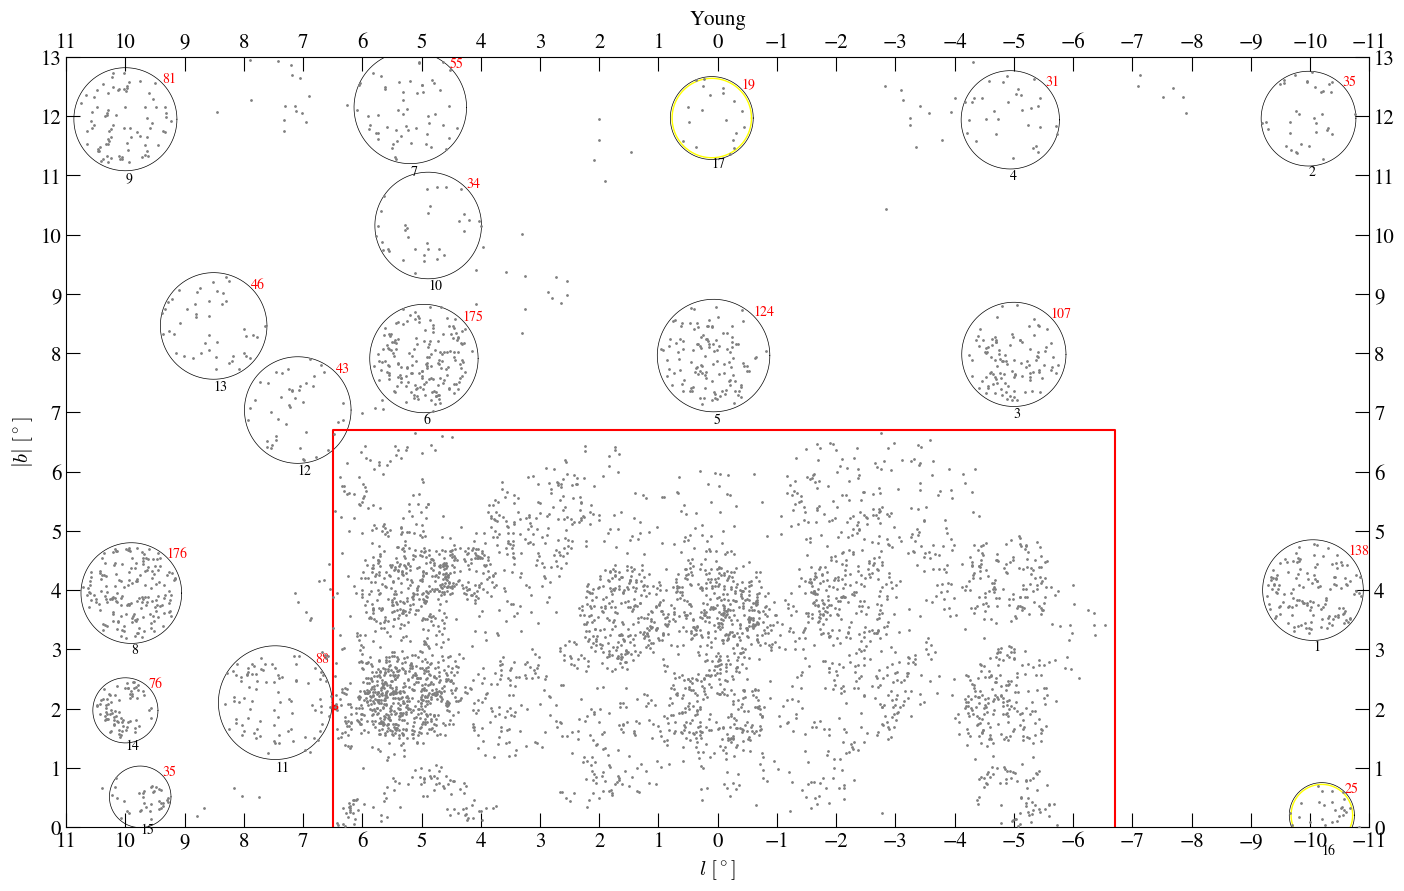

In [1229]:
# plot

x_values = df_metals[pop_idx][x_variable].values
y_values = df_metals[pop_idx][y_variable].values

circle_radii, circle_centres = get_circle_radii_and_centres(pop_idx,below_min_number=True)

filepath = save_path + f"blobs_counts_%s_min{min_star_number_blobs}"%["young","old"][pop_idx]

plot_scatter_with_circles(x_values, y_values, circle_radii, circle_centres, almost_inside_lim=almost_inside_lim, dynamical_region_dict=dynamical_region_dict, 
                          title=["Young","Old"][pop_idx],save_bool=save_bool,filepath=filepath)

## Star number

In [1267]:
vmin,vmax = get_vminvmax_list_for_lb_blobhull_maps(df_all=df_metals, df_hull=df_hull, map_variable_list=["number"],
                                                   min_star_number_dyn=min_star_number_dyn, below_min_number_blobs=True)

if vmin < min_star_number_blobs:
    vmin = min_star_number_blobs
    cbar_extend = "min"
    
cbar_ticks = np.arange(vmin,vmax,30).astype(int)
print(cbar_ticks)

[ 30  60  90 120 150 180 210 240]


In [1231]:
cmap = mplcmaps["viridis"]

cmap.set_under("silver")

In [1232]:
plt.rcParams["font.size"] = 15

In [1233]:
blob_lw = 0.5
lowN_blob_lw = 0.5
lowN_blob_color = "k"
dyn_lw = 0.5

bin_generator_scatter_bool = False
scatter_bool = True
scatter_alpha = 1
scatter_size = 0.2
scatter_color = "red"

In [1234]:
aspect_equal = True
# aspect_equal = False

# save_bool = True
save_bool = False

dynblobs_counts_0R3.5_min50dyn_min30blobs


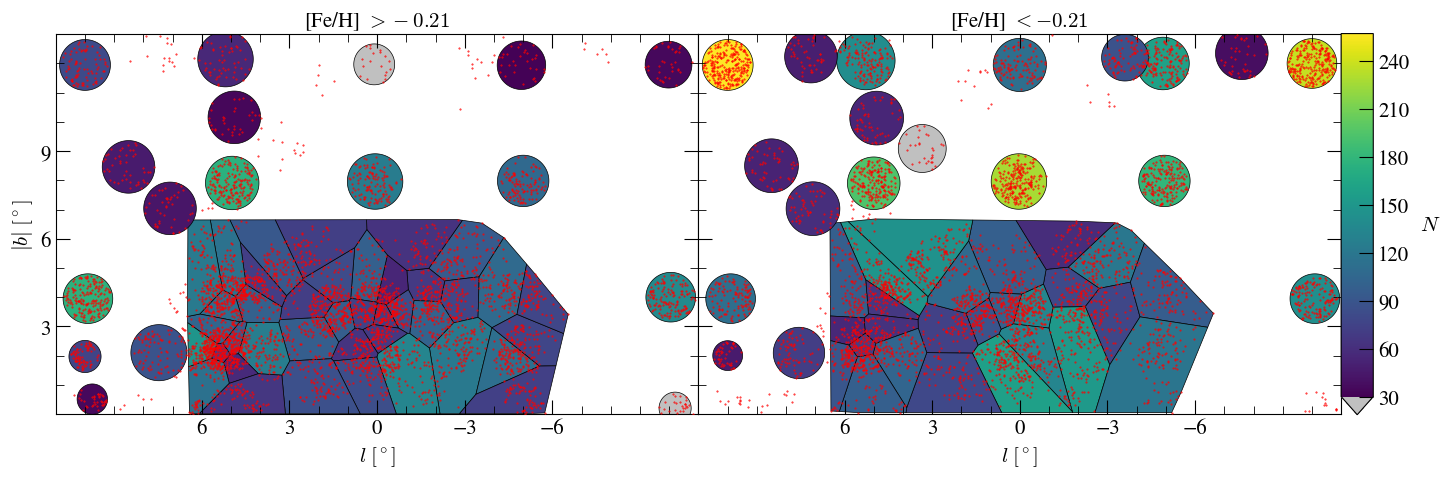

In [1235]:
norm = plt.Normalize(vmin,vmax)

fig,axs=plt.subplots(figsize=(17,4.95),ncols=3,gridspec_kw={"wspace":0,"width_ratios":[1,1,0.05]})

for col in range(len(df_metals)):

    ax = axs[col]

    ax.set_title([label_rich,label_poor][col])

    if True: # dynamical hull
        x_values_dyn = df_hull[col][x_variable].values
        y_values_dyn = df_hull[col][y_variable].values
        input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

        pts = MultiPoint([Point(i) for i in input_points_dyn])
        mask = pts.convex_hull

        vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, min_star_number_dyn)
        point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn)
        computed_values = dyn.compute_values(vor.regions, df_hull[col], point_region, compute_variable_function="counts")

        for i, cell_vertices in enumerate(vor.regions):
            polygon = vor.vertices[cell_vertices]

            shape = list(polygon.shape)
            shape[0] += 1
            p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

            ax.fill(*p.exterior.coords.xy, lw=dyn_lw, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

    if True: # blobs
        all_x_values = df_metals[col][x_variable].values
        all_y_values = df_metals[col][y_variable].values

        circle_radii, circle_centres = get_circle_radii_and_centres(pop_idx=col,below_min_number=True)

        for radius,centre in zip(circle_radii,circle_centres):
            circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

            points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

            value = sum(points_inside)

            edge_color = lowN_blob_color if sum(points_inside) < min_star_number_blobs else "k"
            lw = lowN_blob_lw if sum(points_inside) < min_star_number_blobs else blob_lw

            ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

    if scatter_bool:
        ax.scatter(all_x_values,all_y_values,color=scatter_color,alpha=scatter_alpha,s=scatter_size,zorder=10)
    if bin_generator_scatter_bool:
        ax.scatter(points[:,0],points[:,1],color="cyan",alpha=bin_generator_scatter_alpha,s=bin_generator_scatter_size,zorder=10)

    if True: # axs

        ax.set_xticks(mapf.get_map_tick_range(lmin,lmax,tick_step))
        ax.set_yticks(mapf.get_map_tick_range(bmin,bmax,tick_step))

        ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[x_variable]))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[y_variable]))

        if col == 0:
            ax.set_ylabel(fr"{variable_symbol_dict[y_variable]} $[{units_dict[y_variable]}]$")
        elif col != 0:
            ax.set_yticklabels([])

        ax.set_xlabel(fr"{variable_symbol_dict[x_variable]} $[{units_dict[x_variable]}]$")
        
        if aspect_equal:
            ax.set_aspect("equal")
        
        ax.set_xlim(lmax,lmin)
        ax.set_ylim(bmin,bmax)

if True: # colorbar
    cax = axs[2]

    cbar = plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), cax=cax, extend="min")#,shrink=0.7)
    cbar.set_label(r"$N$",labelpad=15,rotation=0)
    cbar.set_ticks(cbar_ticks)
    
if True: # save
    filename = f"dynblobs_counts{extra_var_string}_min{min_star_number_dyn}dyn_min{min_star_number_blobs}blobs"
    
    if save_bool:
        print(save_path+filename)
        for fileformat in [".png",".pdf"]:
            plt.savefig(save_path+filename+fileformat, bbox_inches='tight',dpi=300)
            print("Saved:",fileformat)
    else:
        print(filename)

## Double plot

In [1273]:
# CHOOSE

# doublemap_variable_list = [["anisotropy","correlation","tilt_abs"], ["anisotropy_error","correlation_error","tilt_abs_error"]]
doublemap_variable_list = [["anisotropy","correlation","tilt_abs"], ["anisotropy_fractionalerror","correlation_fractionalerror","tilt_abs_fractionalerror"]]
# doublemap_variable_list = [["mean_vx","mean_vy"],["std_vx","std_vy"]]

left_maps = doublemap_variable_list[0]
right_maps = doublemap_variable_list[1]

In [1295]:
def get_doublemap_gridspec_params(variables, n_rows):
    if variables == "lb":
        if n_rows == 2:
            fig_size = 7
            fig_aspect_ratio = 2.3*(lmax-lmin)/(bmax-bmin)
            central_space = 0.51
            cbar_width = 0.05
#             fig_size = 7
#             fig_aspect_ratio = 2.3*(x_max-x_min)/(y_max-y_min)
#             central_space = 0.51
#             cbar_width = 0.05
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
            plt.rcParams['font.size'] = 26
        elif n_rows == 3:
            fig_size = 10
            fig_aspect_ratio = 4.52/3*(lmax-lmin)/(bmax-bmin)
            central_space = 0.47
            cbar_width = 0.05
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
            plt.rcParams['font.size'] = 26
        else:
            raise NotImplementedError(f"Not implemented for {n_rows} rows.")
    else:
        raise NotImplementedError(f"Not implemented for {variables}.")
            
    return fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize

In [1269]:
sharing_cbar_bool = True
# sharing_cbar_bool = False

if sharing_cbar_bool:
    
    shared_cbar_variables = []
    
    shared_cbar_variables.append(["std_vx","std_vy"])
        
    print("Sharing all of the following map pairs (when they exists):\n")
    for shared in shared_cbar_variables:
        print(shared)

Sharing all of the following map pairs (when they exists):

['std_vx', 'std_vy']


In [1270]:
# below_min_number_blobs = True
below_min_number_blobs = False

In [1271]:
# Ensure that the boostrap errors computed to get the vmin and vmax are the same as they are then computed when producing the plot
np.random.seed(1)

In [1346]:
# calculate vmin,vmax

vmin_list_left, vmax_list_left, extend_list_left =\
get_vminvmax_extend_lists_for_lb_blobhull_maps(df_metals, df_hull, map_variable_list=left_maps,min_star_number_dyn=min_star_number_dyn,\
                                       below_min_number_blobs=below_min_number_blobs,bootstrap_repeat=500, x_variable=x_variable, y_variable=y_variable)

vmin_list_right, vmax_list_right, extend_list_right =\
get_vminvmax_extend_lists_for_lb_blobhull_maps(df_metals, df_hull,map_variable_list=right_maps,min_star_number_dyn=min_star_number_dyn,\
                                       below_min_number_blobs=below_min_number_blobs,bootstrap_repeat=500, x_variable=x_variable, y_variable=y_variable)

if sharing_cbar_bool:
    mapf.share_vminvmax_given_vminvmax_lists(left_maps, shared_cbar_variables, vmin_list_left, vmax_list_left)
    mapf.share_vminvmax_given_vminvmax_lists(right_maps, shared_cbar_variables, vmin_list_right, vmax_list_right)

vmin_double_list = [vmin_list_left, vmin_list_right]
vmax_double_list = [vmax_list_left, vmax_list_right]
extend_double_list = [extend_list_left, extend_list_right]

In [1318]:
# scatter_bool = True
scatter_bool = False

if scatter_bool:
    scatter_alpha = 0.5
    scatter_size = 0.1
    scatter_color="grey"

In [1319]:
blob_lw = 0.5
dyn_lw = 0.5

lowN_blob_lw = 2
lowN_blob_color = "yellow"

In [1320]:
aspect_equal = True
# aspect_equal = False

# save_bool = True
save_bool = False

here
/Users/Luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/dynamical_binning/blobs/-11l11_0b13/0R3.5/-1metal/Noneto-0.21_-0.21toNone/min30blobs/min50dyn/lb_dynblobs_doublemap_anisotropy_correlation_boot500


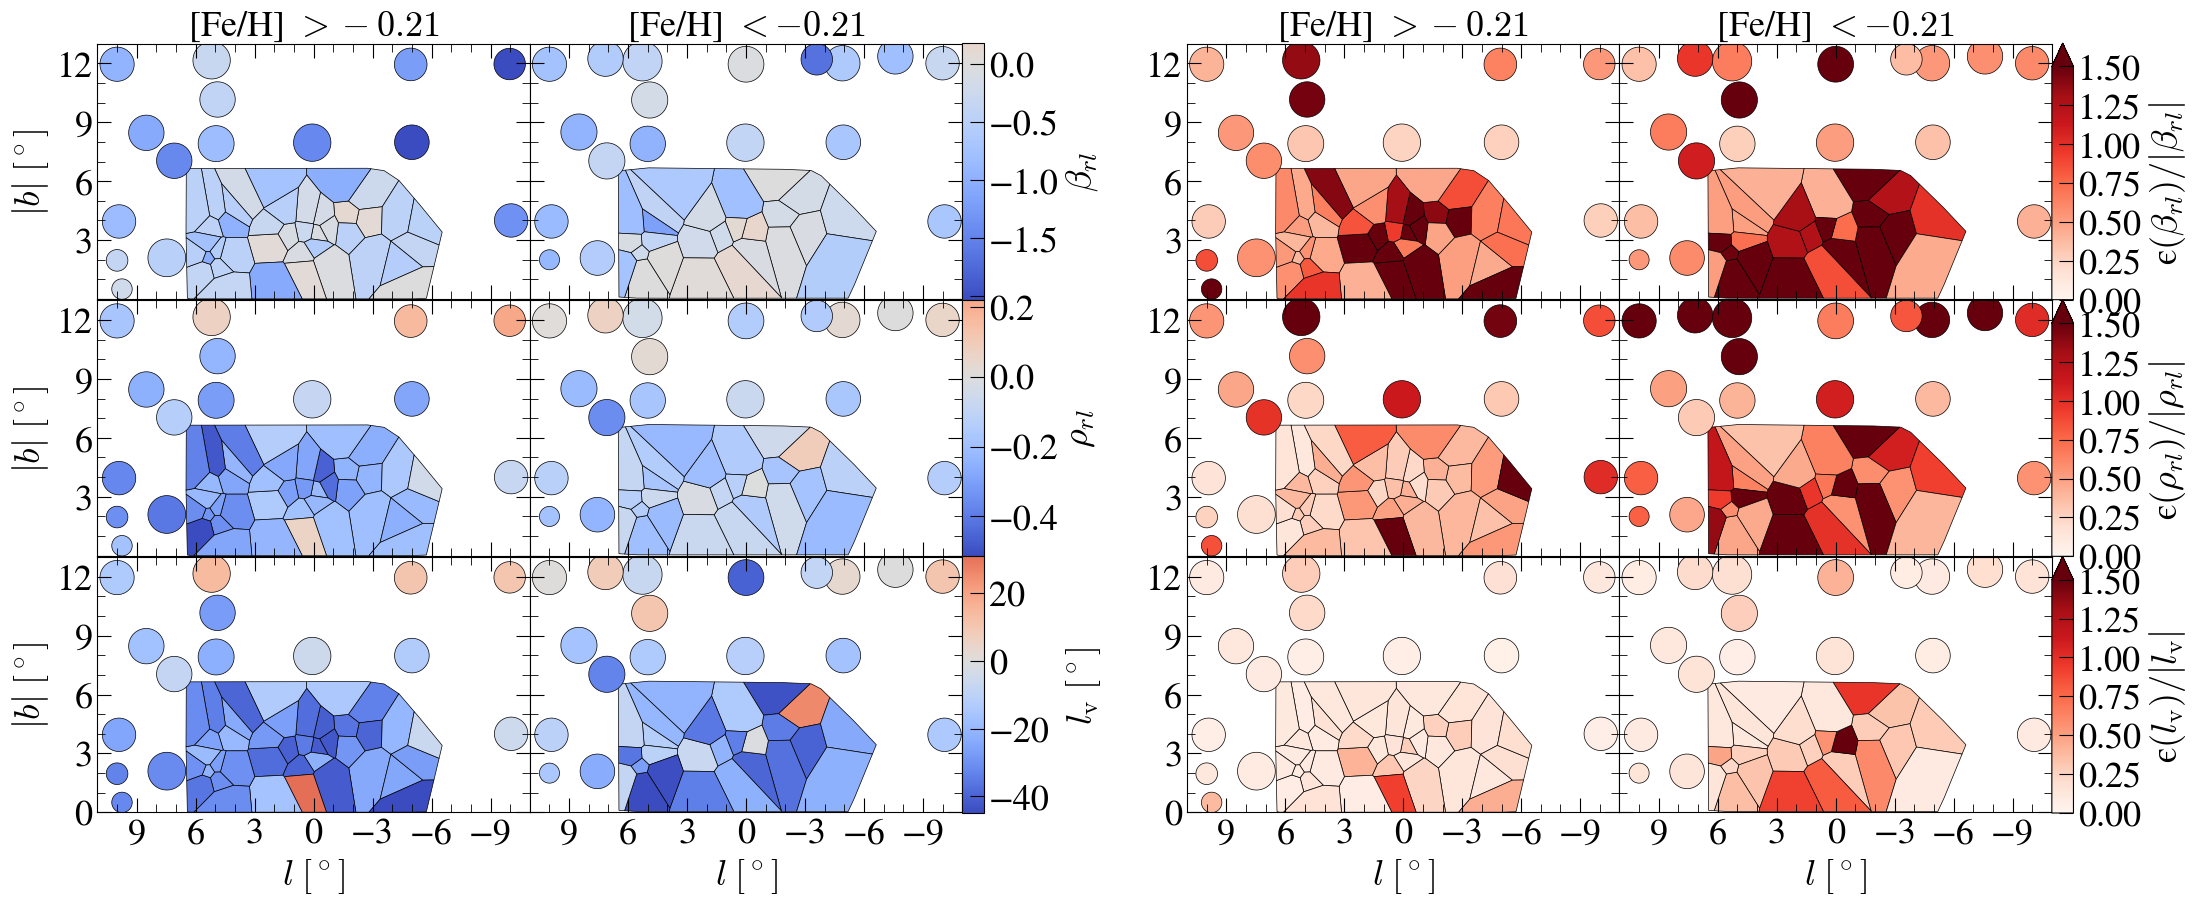

In [1351]:
# Plot

if True: # define fig and axes
    n_rows = len(left_maps)
    n_cols = 7
    
    fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize = get_doublemap_gridspec_params(x_variable+y_variable, n_rows)
    grid = gridspec.GridSpec(n_rows,n_cols,width_ratios=[1, 1, cbar_width, central_space, 1, 1, cbar_width], hspace=0,wspace=0)
    fig = plt.figure(figsize=(fig_aspect_ratio*fig_size,fig_size))
    
    leftaxs = np.reshape([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j in [0,1]], (n_rows,2))
    leftaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 2]

    rightaxs = np.reshape([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j in [4,5]], (n_rows,2))
    rightaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 6]

    axes = [leftaxs,rightaxs]
    axes_cbar = [leftaxs_cbars,rightaxs_cbars]

for block in range(len(doublemap_variable_list)):
    for row in range(n_rows):
        variable = doublemap_variable_list[block][row]

        kws, compute_variable = get_kws_and_compute_variable_function(variable)

        vmin, vmax, cbar_extend = vmin_double_list[block][row], vmax_double_list[block][row], extend_double_list[block][row]

        cmap = PH.choose_cmap(vmin,vmax)
        norm = plt.Normalize(vmin,vmax)

        for col in range(len(df_metals)):

            ax = axes[block][row][col]
            
            if row == 0: ax.set_title([label_rich,label_poor][col])

            if True: # dynamical hull
                x_values_dyn = df_hull[col][x_variable].values
                y_values_dyn = df_hull[col][y_variable].values
                input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

                pts = MultiPoint([Point(i) for i in input_points_dyn])
                mask = pts.convex_hull

                vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, min_star_number_dyn)
                point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn)
                computed_values = dyn.compute_values(vor.regions, df_hull[col], point_region, compute_variable_function=compute_variable,**kws)

                for i, cell_vertices in enumerate(vor.regions):
                    polygon = vor.vertices[cell_vertices]

                    shape = list(polygon.shape)
                    shape[0] += 1
                    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

                    ax.fill(*p.exterior.coords.xy, lw=dyn_lw, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

            if True: # blobs
                all_x_values = df_metals[col][x_variable].values
                all_y_values = df_metals[col][y_variable].values

                circle_radii, circle_centres = get_circle_radii_and_centres(pop_idx=col, below_min_number=below_min_number_blobs)

                for radius,centre in zip(circle_radii,circle_centres):
                    circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

                    points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

                    value = compute_variable(df_metals[col].iloc[points_inside], **kws)

                    edge_color = lowN_blob_color if sum(points_inside) < min_star_number_blobs else "k"
                    lw = lowN_blob_lw if sum(points_inside) < min_star_number_blobs else blob_lw

                    ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

            if scatter_bool: ax.scatter(all_x_values,all_y_values,color=scatter_color,alpha=scatter_alpha,s=scatter_size,zorder=10)
                
            if True: # axs
                
                x_ticks = mapf.get_map_tick_range(lmin,lmax,tick_step)
                y_ticks = mapf.get_map_tick_range(bmin,bmax,tick_step)
                
                ax.set_xticks(x_ticks)
                ax.set_yticks(y_ticks)
                
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[x_variable]))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_locator_dict[y_variable]))
                
                if block == 0 and col == 0:
                    ax.set_ylabel(fr"{variable_symbol_dict[y_variable]} $[{units_dict[y_variable]}]$")
                elif col != 0:
                    ax.set_yticklabels([])
                    
                if col==0 and row != n_rows-1:
                    if x_variable+y_variable=="lb" and bmax - max(y_ticks) <= 1:
                        ax.set_yticklabels([None]+y_ticks[1:])

                if row == n_rows-1: 
                    ax.set_xlabel(fr"{variable_symbol_dict[x_variable]} $[{units_dict[x_variable]}]$")
                else:
                    ax.set_xticklabels([])
                
                if aspect_equal:
                    ax.set_aspect("equal")
                    
                ax.set_xlim(lmax,lmin)
                ax.set_ylim(bmin,bmax)
        
        if True: # colorbar
            cax = axes_cbar[block][row]
            
            cbar = plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), cax=cax, label=kinematic_symbols_dict[variable]+kinematic_units_dict[variable],\
                               extend=cbar_extend, extendfrac=0.1)#,shrink=0.7)
            cbar.ax.locator_params(nbins=6)
            
for block in range(len(doublemap_variable_list)): # remove overlapping ticks
    for row in range(n_rows - 1):
        current_vminvmax = [vmin_double_list[block][row],vmax_double_list[block][row]]
        next_vminvmax = [vmin_double_list[block][row+1],vmax_double_list[block][row+1]]
        
        current_cbar_extend, next_cbar_extend = extend_double_list[block][row], extend_double_list[block][row+1]
        
        if current_cbar_extend in ["min","both"] or next_cbar_extend in ["max","both"]:
            continue
        
        mapf.remove_overlapping_ticks(axes_cbar[block][row], axes_cbar[block][row+1], current_vminvmax, next_vminvmax, which="bottom")

if True: # filename and save
    fig.align_labels()
    
    below_min_n_str = "_belowMinN" if below_min_number_blobs else ""
    scatter_string = "_scatter" if scatter_bool else ""
    edges_string = "_noEdges" if dyn_lw == 0 and blob_lw == 0 else ""
    
    maps_string = f"_{left_maps[0]}_{left_maps[1]}"
    maps_string += "_sharing" if sharing_cbar_bool and mapf.any_map_pair_is_shared(doublemap_variable_list, shared_cbar_variables) else ""
    
    filename = f"{x_variable}{y_variable}_dynblobs_doublemap{maps_string}{scatter_string}{edges_string}{below_min_n_str}"
    
    _all_maps = MF.flatten_list(list(doublemap_variable_list))
    if any("error" in map_var for map_var in _all_maps):
        filename += f"_boot{bootstrap_repeat}"
    
    print(save_path+filename)
    
    if save_bool:
        for fileformat in [".png",".pdf"]:
            plt.savefig(save_path+filename+fileformat, bbox_inches='tight',dpi=300)
            print("Saved:",fileformat)

plt.show()

## Single plot

'40'

In [466]:
# CHOOSE

# map_variable_list = ["mean_vx","mean_vy","varx","vary"]
map_variable_list = ["anisotropy","correlation","tilt_abs"]
# map_variable_list = ["anisotropy_error","correlation_error","tilt_abs_error"]
# map_variable_list = ["anisotropy","anisotropy_error","correlation","correlation_error","tilt_abs","tilt_abs_error"]

for variable in map_variable_list: print(variable)

anisotropy
correlation
tilt_abs


In [467]:
vmin_list, vmax_list = get_vminvmax_list_for_lb_blobhull_maps(df_metals, df_hull, map_variable_list=map_variable_list, min_star_number_dyn=min_star_number_dyn,
                                                              bootstrap_repeat=500, x_variable=x_variable, y_variable=y_variable)

In [118]:
fig_size = 20
cbar_width = 0.035

def get_fig_aspect_ratio(n_rows):
    if n_rows == 3:
        return 1.1
    elif n_rows == 4:
        return 1
    else:
        raise NotImplementedError(f"Not implemented for {n_rows} rows")

In [431]:
scatter_bool = True
# scatter_bool = False

# aspect_equal = True
aspect_equal = False

# save_bool = True
save_bool = False

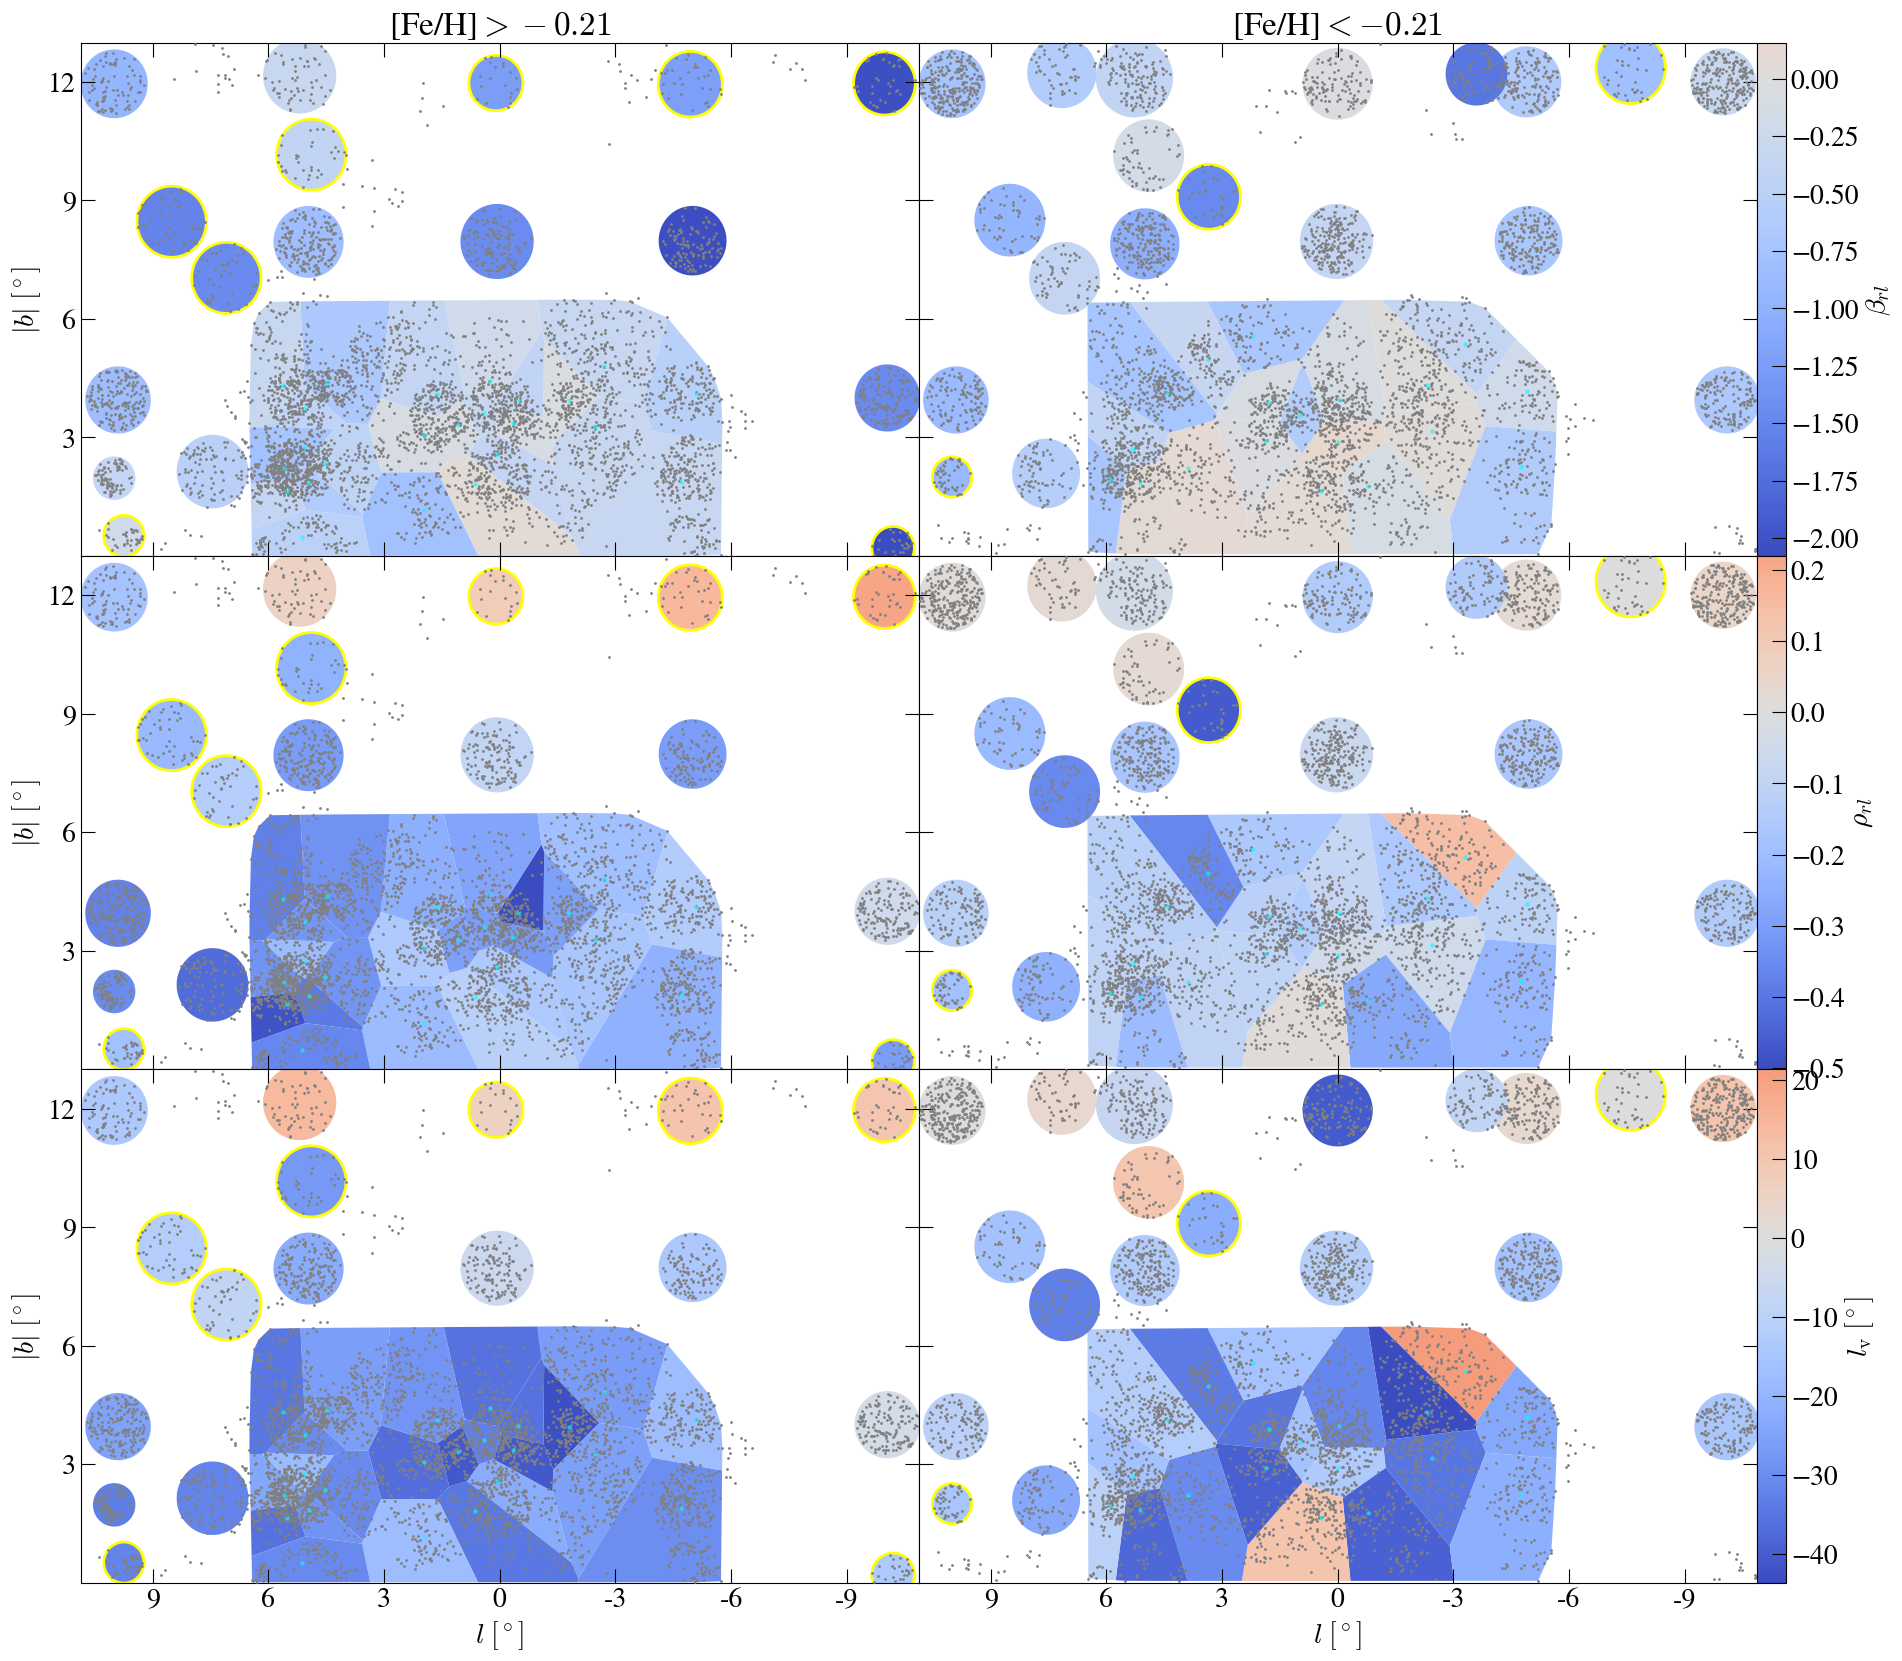

In [432]:
# Plot

n_rows = len(map_variable_list)
n_cols = len(df_metals) + 1 # includes cbar

grid = gridspec.GridSpec(n_rows,3,width_ratios=[1, 1, cbar_width], hspace=0,wspace=0)

fig = plt.figure(figsize=(get_fig_aspect_ratio(n_rows)*fig_size,fig_size))
axes = np.array([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols)]).reshape((n_rows,n_cols))

for row,variable in enumerate(map_variable_list):

    kws, compute_variable = get_kws_and_compute_variable_function(variable)
    
    vmin, vmax = vmin_list[row], vmax_list[row]
    
    cmap = PH.choose_cmap(vmin,vmax)
    norm = plt.Normalize(vmin,vmax)

    row_axs = axes[row]
    
    for col in range(len(df_metals)+1):

        ax = row_axs[col]

        if col == 2:
            plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), cax=ax, label=kinematic_symbols_dict[variable]+kinematic_units_dict[variable])#,shrink=0.7)
            continue

        if True: # calculate dynamical hull
            x_values_dyn = df_hull[col][x_variable].values
            y_values_dyn = df_hull[col][y_variable].values
            input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

            pts = MultiPoint([Point(i) for i in input_points_dyn])
            mask = pts.convex_hull

            vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, min_star_number_dyn)
            point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn)
            computed_values = dyn.compute_values(vor.regions, df_hull[col], point_region, compute_variable_function=compute_variable,**kws)
            
            for i, cell_vertices in enumerate(vor.regions):
                polygon = vor.vertices[cell_vertices]

                shape = list(polygon.shape)
                shape[0] += 1
                p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

                ax.fill(*p.exterior.coords.xy, lw=0, facecolor=cmap(norm(computed_values[i])))

        if True: # blobs
            all_x_values = df_metals[col][x_variable].values
            all_y_values = df_metals[col][y_variable].values

            circle_radii, circle_centres = get_circle_radii_and_centres(pop_idx=col)
            
            for radius,centre in zip(circle_radii,circle_centres):
                circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

                points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

                value = compute_variable(df_metals[col].iloc[points_inside], **kws)

                edge_color = "yellow" if sum(points_inside) < min_star_number_blobs else "k"
                lw = 2 if sum(points_inside) < min_star_number_blobs else 0

                ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))
        
        # ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
        
        if scatter_bool:
            ax.scatter(all_x_values,all_y_values,color="grey",s=1,zorder=10)
            ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5,zorder=10)
        
if True: #axs
    x_label = fr"{variable_symbol_dict[x_variable]} $[{units_dict[x_variable]}]$"
    y_label = fr"{variable_symbol_dict[y_variable]} $[{units_dict[y_variable]}]$"

    x_ticks = get_map_tick_range(x_variable)
    y_ticks = get_map_tick_range(y_variable)
    
    for ax in axes.flatten():
        if ax in axes[:,2]:
            continue
        
        ax.set_xticklabels(x_ticks if ax in axes[-1] else [])
        ax.set_yticklabels(y_ticks if ax in axes[:,0] else [])
        
        ax.set_xlabel(x_label if ax in axes[-1] else "")
        ax.set_ylabel(y_label if ax in axes[:,0] else "")

        if aspect_equal:
            ax.set_aspect("equal")

        axes[0,0].set_title(label_rich)
        axes[0,1].set_title(label_poor)
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        ax.set_xlim(lmax,lmin)
        ax.set_ylim(bmin,bmax)
        
if save_bool:
    extra_var_string = f"{dmin}d{dmax}"
    
    filename = f"{x_variable}{y_variable}_dynmap_{extra_var_string}_{map_variables[-2]}_{map_variables[-1]}_min{min_star_number_dyn}dyn_min{min_star_number_blobs}blobs"

    if any("error" in map_var for map_var in map_variables):
        filename += f"_boot{bootstrap_repeat}"

    if scatter_bool:
        filename += "_scatter"

    plt.savefig(save_path+filename+".png", bbox_inches='tight',dpi=300)
    plt.savefig(save_path+filename+".pdf", bbox_inches='tight')
    print(save_path+filename)
plt.show()